In [5]:
import numpy as np
import netCDF4 as nc
import auxiliary as au
import regression as reg
import datetime as dt
from matplotlib import pyplot as plt
from scipy import io
from scipy.interpolate import interp2d
import os
import sys
from scipy.interpolate import griddata
import h5py

def demread(file,lattar,lontar):
    datatemp = io.loadmat(file)
    demori = datatemp['DEM']
    demori[np.isnan(demori)] = 0
    info = datatemp['Info'][0][0]
    latori = np.arange(info['yll'] + info['Ysize'] * info['nrows'] - info['Ysize'] / 2, info['yll'], -info['Ysize'])
    lonori = np.arange(info['xll'] + info['Xsize'] / 2, info['xll'] + info['Xsize']*info['ncols'] , info['Xsize'])
    f = interp2d(lonori, latori, demori, kind='linear')
    demtar = f(lontar.flatten(), lattar.flatten())
    demtar = np.flipud(demtar)
    return demtar

def ncread(file, var):
    # read a variable from netcdf
    ncfid = nc.Dataset(file)
    data = ncfid[var][:].data
    ncfid.close()
    return data


def neargrid(rowtar, coltar, rowori, colori, hwsize):
    # inputs are 1D matrices
    # tar is target area
    # ori is original area
    # hwsize is half window size (e.g., 4 means the space window width/length is 2*4+1)
    # find a space window centering the target grid in the original area and calculate the weights
    nrows = len(rowtar)
    ncols = len(coltar)
    rowse = np.zeros([nrows, ncols, 2]).astype(int)  # se: start/end
    colse = np.zeros([nrows, ncols, 2]).astype(int)   # se: start/end
    weight = np.nan * np.zeros([nrows, ncols, (hwsize * 2 + 1) ** 2])  # from left to right/from top to bottom weight

    for rr in range(nrows):
        rowloc = np.argmin(np.abs(rowori - rowtar[rr]))
        rowse[rr, :, 0] = rowloc - hwsize
        rowse[rr, :, 1] = rowloc + hwsize

    for cc in range(ncols):
        colloc = np.argmin(np.abs(colori - coltar[cc]))
        colse[:, cc, 0] = colloc - hwsize
        colse[:, cc, 1] = colloc + hwsize

    rowse[rowse < 0] = 0
    rowse[rowse > nrows] = nrows
    colse[colse < 0] = 0
    colse[colse > ncols] = nrows

    maxdist = (hwsize + 0.5) * np.sqrt(2) + 0.5
    for rr in range(nrows):
        rowloc = np.argmin(np.abs(rowori - rowtar[rr]))
        for cc in range(ncols):
            colloc = np.argmin(np.abs(colori - coltar[cc]))

            rowse_rc = rowse[rr, cc, :]
            colse_rc = colse[rr, cc, :]
            flag = 0
            for i in range(rowse_rc[0], rowse_rc[1] + 1):
                for j in range(colse_rc[0], colse_rc[1] + 1):
                    dist = ((rowloc - i) ** 2 + (colloc - j) ** 2) ** 0.5
                    weight[rr, cc, flag] = au.distanceweight(dist, maxdist, 3)
                    flag = flag + 1

            weight[rr, cc, :] = weight[rr, cc, :] / np.nansum(weight[rr, cc, :])

    return rowse, colse, weight

def readownscale(dataori,latori,lonori,demori,lattar,lontar,demtar,rowse,colse,weight,mask):
    nrows = len(lattar)
    ncols = len(lontar)
    ntimes = np.shape(dataori)[2]
    lonori,latori = np.meshgrid(lonori,latori)
    datatar = np.nan * np.zeros([nrows,ncols,ntimes])
    for tt in range(2):
        print('tt', tt)
        for rr in range(nrows):
            for cc in range(ncols):
                if mask[rr,cc] == 1:
                    rloc = rowse[rr, cc, :]
                    cloc = colse[rr, cc, :]
                    datanear = dataori[rloc[0]:rloc[1]+1, cloc[0]:cloc[1]+1, tt]
                    nnum = np.size(datanear)
                    datanear = np.reshape(datanear,nnum)
                    latnear = latori[rloc[0]:rloc[1]+1, cloc[0]:cloc[1]+1]
                    latnear = np.reshape(latnear, nnum)
                    lonnear = lonori[rloc[0]:rloc[1]+1, cloc[0]:cloc[1]+1]
                    lonnear = np.reshape(lonnear, nnum)
                    demnear = demori[rloc[0]:rloc[1]+1, cloc[0]:cloc[1]+1]
                    demnear = np.reshape(demnear, nnum)
                    weightnear = np.zeros([nnum,nnum])
                    for i in range(nnum):
                        weightnear[i,i] = weight[rr,cc,i]

                    nearinfo = np.zeros([nnum,4])
                    nearinfo[:,0] = 1
                    nearinfo[:,1] = latnear
                    nearinfo[:, 2] = lonnear
                    nearinfo[:, 3] = demnear

                    tarinfo = np.zeros(4)
                    tarinfo[0] = 1
                    tarinfo[1] = lattar[rr]
                    tarinfo[2] = lontar[cc]
                    tarinfo[3] = demtar[rr,cc]

                    tx_red = np.transpose(nearinfo)
                    twx_red = np.matmul(tx_red, weightnear)
                    b = reg.least_squares(nearinfo, datanear, twx_red)
                    if np.all(b==0):
                        weightnear = weight[rr, cc, 0:nnum]
                        mloc = np.argmax(weightnear)
                        datatar[rr, cc, tt] = datanear[mloc]
                    else:
                        datatar[rr, cc, tt] = np.dot(tarinfo, b)

    return datatar





# basic information
filedem = './DEM/NA_DEM_010deg_trim.mat'
year = [1979, 1979]
vars = ['prcp','tmin','tmax']
lontar = np.arange(-180 + 0.05, -50, 0.1)
lattar = np.arange(85-0.05, 5, -0.1)
hwsize = 2

datatemp = io.loadmat(filedem)
demtar = datatemp['DEM'] # this is consistent with lontar lattar

mask = demtar.copy()
mask[~np.isnan(mask)] = 1

# ERA-5
filedem_era = './DEM/ERA5_DEM2.mat'
inpath = '/Users/localuser/Research/Test'
outpath = '/Users/localuser/Research'
filenear = outpath + '/neargrid.npz'

for y in range(year[0], year[1] + 1):
    for v in range(1):
        print('year--var:',y,v)
        infile = inpath + '/ERA5_' + vars[v] + '_' + str(y) + '.mat'
        outfile = outpath + '/ERA5_' + vars[v] + '_' + str(y) + '.mat'
        if os.path.isfile(outfile):
            continue

        # load original daily reanalysis data
        datatemp = {}
        f = h5py.File(infile)
        for k, v in f.items():
            datatemp[k] = np.array(v)
        latori = datatemp['latitude'][0]
        lonori = datatemp['longitude'][0]
        dataori = datatemp['data']
        dataori = np.transpose(dataori,[2,1,0])
        del datatemp
        f.close()

        # extract ori dem
        demori = demread(filedem_era, latori, lonori)

        # read location information
        if not os.path.isfile(filenear):
            rowse, colse, weight = neargrid(lattar,lontar,latori,lonori,hwsize)
            io.savemat(filenear,{'rowse':rowse, 'colse':colse, 'weight':weight})
        else:
            datatemp = io.loadmat(filenear)
            rowse = datatemp['rowse']
            colse = datatemp['colse']
            weight = datatemp['weight']
            del datatemp

        # downscale the reanalysis to 0.1 degree
        datatar = readownscale(dataori, latori, lonori, demori, lattar, lontar, demtar, rowse, colse, weight, mask)
        io.savemat(outfile,{'data':datatar,'latitude':lattar,'longitude':lontar})

year--var: 1979 0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:164: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.


tt 0
tt 1


In [31]:
outfile2 = '/Users/localuser/Research/ERA5_prcp_1979---.npz'
np.savez_compressed(outfile2,data=datatar,latitude=lattar,longitude=lontar)

In [32]:
lontar

array([-179.95, -179.85, -179.75, ...,  -50.25,  -50.15,  -50.05])

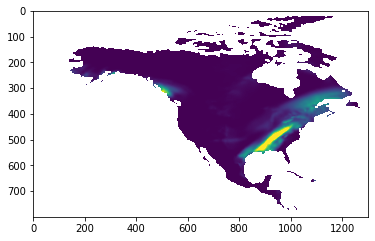

In [29]:
plt.imshow(datatar[:,:,0])
plt.clim([0,30])

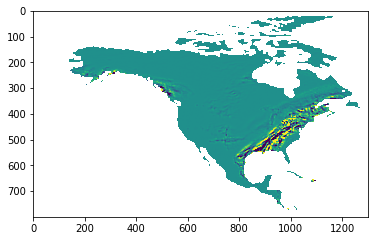

In [23]:
diff = datatar[:,:,0] - pp[:,:,0]
plt.imshow(diff)
plt.clim([-1,1])

(array([6.00000e+00, 5.50000e+01, 1.74000e+02, 6.08000e+02, 3.30300e+03,
        3.10008e+05, 8.71000e+03, 6.64000e+02, 8.50000e+01, 1.10000e+01]),
 array([-9.19081826, -7.57175419, -5.95269013, -4.33362606, -2.71456199,
        -1.09549793,  0.52356614,  2.14263021,  3.76169427,  5.38075834,
         6.99982241]),
 <a list of 10 Patch objects>)

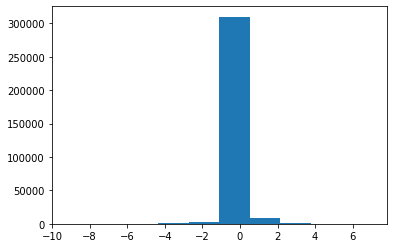